---
title: "Classifying movie reviews: a binary classification example"
output: 
  html_notebook: 
    theme: cerulean
    highlight: textmate
---



***

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with R](https://www.manning.com/books/deep-learning-with-r). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

***

Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [4]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
library(keras)

imdb <- dataset_imdb(num_words = 10000)
c(c(train_data, train_labels), c(test_data, test_labels)) %<-% imdb

The argument `num_words = 10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [6]:
str(train_data[[1]])

 int [1:218] 1 14 22 16 43 530 973 1622 1385 65 ...


In [7]:
train_labels[[1]]

[1] 1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [8]:
max(sapply(train_data, max))

[1] 9999

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [0]:
# word_index is a dictionary mapping words to an integer index
word_index <- dataset_imdb_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index <- names(word_index)
names(reverse_word_index) <- word_index
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review <- sapply(train_data[[1]], function(index) {
  word <- if (index >= 3) reverse_word_index[[as.character(index - 3)]]
  if (!is.null(word)) word else "?"
})

In [10]:
cat(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## Preparing the data


You can't feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:

* Pad your lists so that they all have the same length, turn them into an integer tensor of shape `(samples, word_indices)`, and then use as the first layer in your network a layer capable of handling such integer tensors (the "embedding" layer, which we'll cover in detail later in the book).
* One-hot-encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence `[3, 5]` into a 10,000-dimensional vector that would be all zeros except for indices 3 and 5, which would be ones. Then you could use as the first layer in your network a dense layer, capable of handling floating-point vector data.

Let's go with the latter solution and vectorize the data, which you'll do manually for maximum clarity.

In [0]:
vectorize_sequences <- function(sequences, dimension = 10000) {
  # Create an all-zero matrix of shape (len(sequences), dimension)
  results <- matrix(0, nrow = length(sequences), ncol = dimension)
  for (i in 1:length(sequences))
    # Sets specific indices of results[i] to 1s
    results[i, sequences[[i]]] <- 1
  results
}

# Our vectorized training data
x_train <- vectorize_sequences(train_data)
# Our vectorized test data
x_test <- vectorize_sequences(test_data)

Here's what our samples look like now:

In [12]:
str(x_train[1,])

 num [1:10000] 1 1 0 1 1 1 1 1 1 0 ...


We should also vectorize our labels, which is straightforward:

In [0]:
# Our vectorized labels
y_train <- as.numeric(train_labels)
y_test <- as.numeric(test_labels)

Now our data is ready to be fed into a neural network.

## Building our network

The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup you'll ever encounter. A type of network that performs well on such a problem is a simple stack of fully connected ("dense") layers with `relu` activations: `layer_dense(units = 16, activation = "relu")`.

The argument being passed to each dense layer (16) is the number of hidden units of the layer. A _hidden unit_ is a dimension in the representation space of the layer. You may remember from chapter 2 that each such dense layer with a `relu` activation implements the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

In the next chapter, you will learn formal principles to guide you in making these choices. For the time being, you will have to trust us with the following architecture choice: two intermediate layers with 16 hidden units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review. The intermediate layers will use `relu` as their "activation function", and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). A `relu` (rectified linear unit) is a function meant to zero-out negative values, while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation, very similar to the MNIST example you saw previously:

In [0]:
library(keras)

model <- keras_model_sequential() %>% 
  layer_dense(units = 16, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 16, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will also monitor accuracy during training.

In [0]:
model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

You're passing your optimizer, loss function, and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy`, and `accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer or pass a custom loss function or metric function. The former can be done by passing an optimizer instance as the `optimizer` argument:

In [0]:
model %>% compile(
  optimizer = optimizer_rmsprop(lr=0.001),
  loss = "binary_crossentropy",
  metrics = c("accuracy")
) 

The latter can be done by passing function objects as the `loss` or `metrics` arguments:

In [0]:
model %>% compile(
  optimizer = optimizer_rmsprop(lr = 0.001),
  loss = loss_binary_crossentropy,
  metrics = metric_binary_accuracy
) 

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data:

In [0]:
val_indices <- 1:10000

x_val <- x_train[val_indices,]
partial_x_train <- x_train[-val_indices,]

y_val <- y_train[val_indices]
partial_y_train <- y_train[-val_indices]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the validation data as the `validation_data` argument:

In [0]:
model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `fit()` returns a `history` object. Let's take a look at it:

In [20]:
str(history)

List of 2
 $ params :List of 7
  ..$ batch_size   : int 512
  ..$ epochs       : int 20
  ..$ steps        : NULL
  ..$ samples      : int 15000
  ..$ verbose      : int 0
  ..$ do_validation: logi TRUE
  ..$ metrics      : chr [1:4] "loss" "acc" "val_loss" "val_acc"
 $ metrics:List of 4
  ..$ loss    : num [1:20] 0.537 0.32 0.231 0.183 0.146 ...
  ..$ acc     : num [1:20] 0.759 0.902 0.928 0.942 0.955 ...
  ..$ val_loss: num [1:20] 0.406 0.325 0.282 0.276 0.292 ...
  ..$ val_acc : num [1:20] 0.857 0.877 0.892 0.891 0.883 ...
 - attr(*, "class")= chr "keras_training_history"


The `history` object includes various parameters used to fit the model (`history$params`) as well as data for each of the metrics being monitored (`history$metrics`).

The `history` object has a `plot()` method that enables us to visualize the training and validation metrics by epoch:

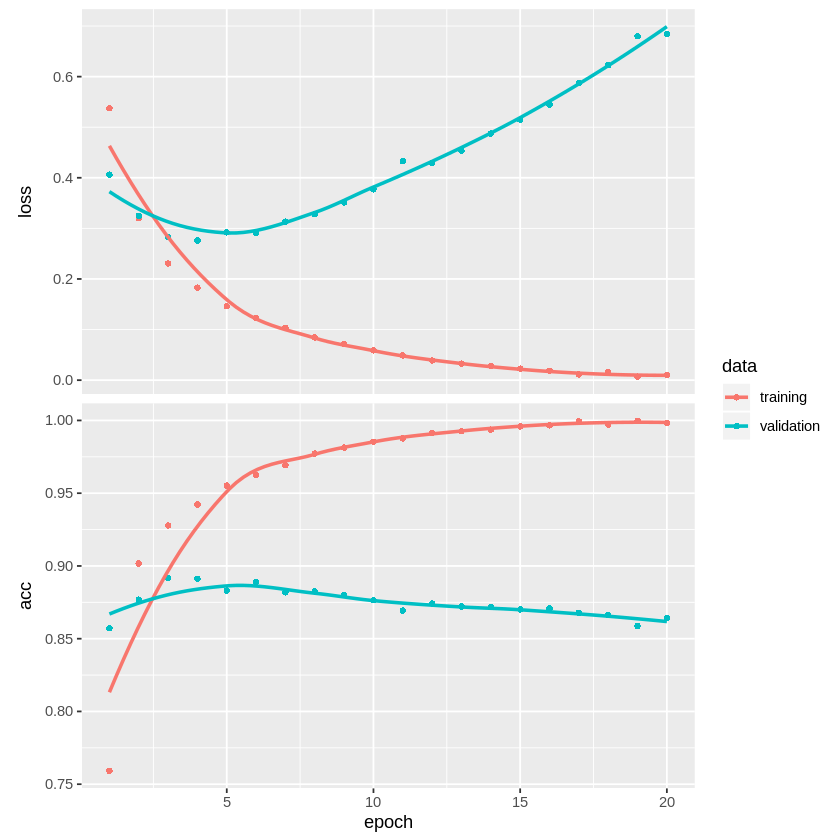

In [21]:
plot(history)

The accuracy is plotted on the top panel and the loss on the bottom panel. Note that your own results may vary 
slightly due to a different random initialization of your network.



The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy. Note that your own results may vary slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That's what you would expect when running a gradient-descent optimization -- the quantity you're trying to minimize should be less with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before. In precise terms, what you're seeing is _overfitting_: after the second epoch, you're over-optimizing on the training data, and you end up learning representations that are specific to the training data and don't generalize to data outside of the training set.

In this case, to prevent overfitting, you could stop training after three epochs. In general, you can use a range of techniques to mitigate overfitting, which we'll cover in chapter 4.

Let's train a new network from scratch for four epochs and then evaluate it on the test data.

In [0]:
model <- keras_model_sequential() %>% 
  layer_dense(units = 16, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 16, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

model %>% fit(x_train, y_train, epochs = 4, batch_size = 512)
results <- model %>% evaluate(x_test, y_test)

In [23]:
results

$loss
[1] 0.2859526

$acc
[1] 0.88684

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, one should be able to get close to 95%.

## Using a trained network to generate predictions on new data

After having trained a network, you'll want to use it in a practical setting. You can generate the likelihood of reviews being positive by using the `predict` method:

In [24]:
model %>% predict(x_test[1:10,])

[,1]      
 [1,] 0.22385538
 [2,] 0.99994934
 [3,] 0.90820855
 [4,] 0.84323633
 [5,] 0.95567256
 [6,] 0.80620867
 [7,] 0.99983644
 [8,] 0.01731458
 [9,] 0.97541887
[10,] 0.99068356

As you can see, the network is very confident for some samples (0.99 or more, or 0.02 or less) but less confident for others. 

## Further experiments


* We were using 2 hidden layers. Try to use 1 or 3 hidden layers and see how it affects validation and test accuracy.
* Try to use layers with more hidden units or less hidden units: 32 units, 64 units...
* Try to use the `mse` loss function instead of `binary_crossentropy`.
* Try to use the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

These experiments will help convince you that the architecture choices we have made are all fairly reasonable, although they can still be improved!

## Conclusions


Here's what you should take away from this example:

* You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it -- as tensors -- into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.
* Stacks of dense layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you'll likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a dense layer with one unit and a `sigmoid` activation. That is, the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice, whatever your problem. That's one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data they've never seen before. Be sure to always monitor performance on data that is outside of the training set.